In [8]:
import matplotlib.pyplot as plt
import numpy as np

(0.0, 5.0, 0.0, 5.0)

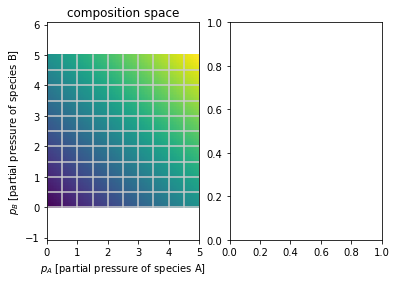

In [30]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

# shared params
p_max = 5.0 # largest pressure we go to.

###
#   color the plane
###
# make these smaller to increase the resolution
dp = 0.05

# generate 2 2d grids for the x & y bounds
pb, pa = np.mgrid[slice(0, p_max + dp, dp),
                slice(0, p_max + dp, dp)]

z = pb + pa

ax[0].pcolormesh(pa, pb, z)

###
#   draw grid lines
###
dp = 0.5
for i in range(int(p_max / dp)):
    ax[0].plot([i * dp, i * dp], [0, p_max], color="0.8")
    ax[0].plot([0, p_max], [i * dp, i * dp], color="0.8")
    
ax[0].axis("equal")